02 Visualize country characteristics
===
Visualizes the chatacteristic values of the observed countries using radar charts. On the y-axis are always the gender questions.
For the x dimension there are three diffrent focuses to plot.
1. One countrie, all waves
2. One countrie, one wave, but Female and Male seperatly
3. All countries one wave
In the end these subplots are combined into one overview


# Refrences
#TODO: Woher habt ihr den Code

In [2]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [3]:
#Data preparation for radar plot
def generate_data(type):
    subset = pd.read_csv('..//data//WVS_cleaned_10.csv')

    listWaves = ['WVS3','WVS4','WVS5','WVS6','WVS7']
    genders=['Male', 'Female']
    questions = ['income_equality', 'divorce', 'abortion','university', 'women_movement', 'politician', 'job', 'choice_control']
    listCountries = ['Germany', 'China', 'Nigeria', 'Turkey', 'Iran', 'Serbia']

    if type == "gender":
        data_gender = []
        data_gender.append(questions)

        for country in listCountries:
            one_country = subset[subset['country'] == country]
            waves = []

            #for wave in listWaves:
            for sex in genders:

                #one_wave = one_country[one_country['wave'] == wave]
                one_gender = one_country[one_country['sex'] == sex]
                normalized_means_wave = []
                for question in questions:
                    #mean per country
                    means_by_country = one_gender[question].mean()

                    if np.isnan(means_by_country):
                        normalized_means_wave.append(0.0)
                    else:
                        #normalized per question -> scale of answers doesnt matter here
                        normalized_means_wave.append(means_by_country / one_gender[question].max())

                waves.append(normalized_means_wave)
            
            country_tuple = (country, waves)
            data_gender.append(country_tuple)
        return data_gender

    if type == "waves":
        data_waves = []
        data_waves.append(questions)

        for country in listCountries:
            one_country = subset[subset['country'] == country]
            waves = []

            for wave in listWaves:

                one_wave = one_country[one_country['wave'] == wave]
                normalized_means_wave = []
                for question in questions:
                    #mean per country
                    means_by_country = one_wave[question].mean()

                    if np.isnan(means_by_country):
                        normalized_means_wave.append(0.0)
                    else:
                        #normalized per question -> scale of answers doesnt matter here
                        normalized_means_wave.append(means_by_country / one_wave[question].max())

                waves.append(normalized_means_wave)
            
            country_tuple = (country, waves)
            data_waves.append(country_tuple)
        return data_waves


    if type == "countries":
        data_countries = []
        data_countries.append(questions)
        countries = []
        for country in listCountries:
            one_country = subset[subset['country'] == country]
            
            one_wave = one_country[one_country['wave'] == 'WVS7']
            normalized_means_wave = []
            for question in questions:
                #mean per country
                means_by_country = one_wave[question].mean()

                if np.isnan(means_by_country):
                    normalized_means_wave.append(0.0)
                else:
                    #normalized per question -> scale of answers doesnt matter here
                    normalized_means_wave.append(means_by_country / one_wave[question].max())

            countries.append(normalized_means_wave)
            
        country_tuple = ('WVS7', countries)
        data_countries.append(country_tuple)
        return data_countries
    



In [4]:
#TODO: Add radar chart code
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

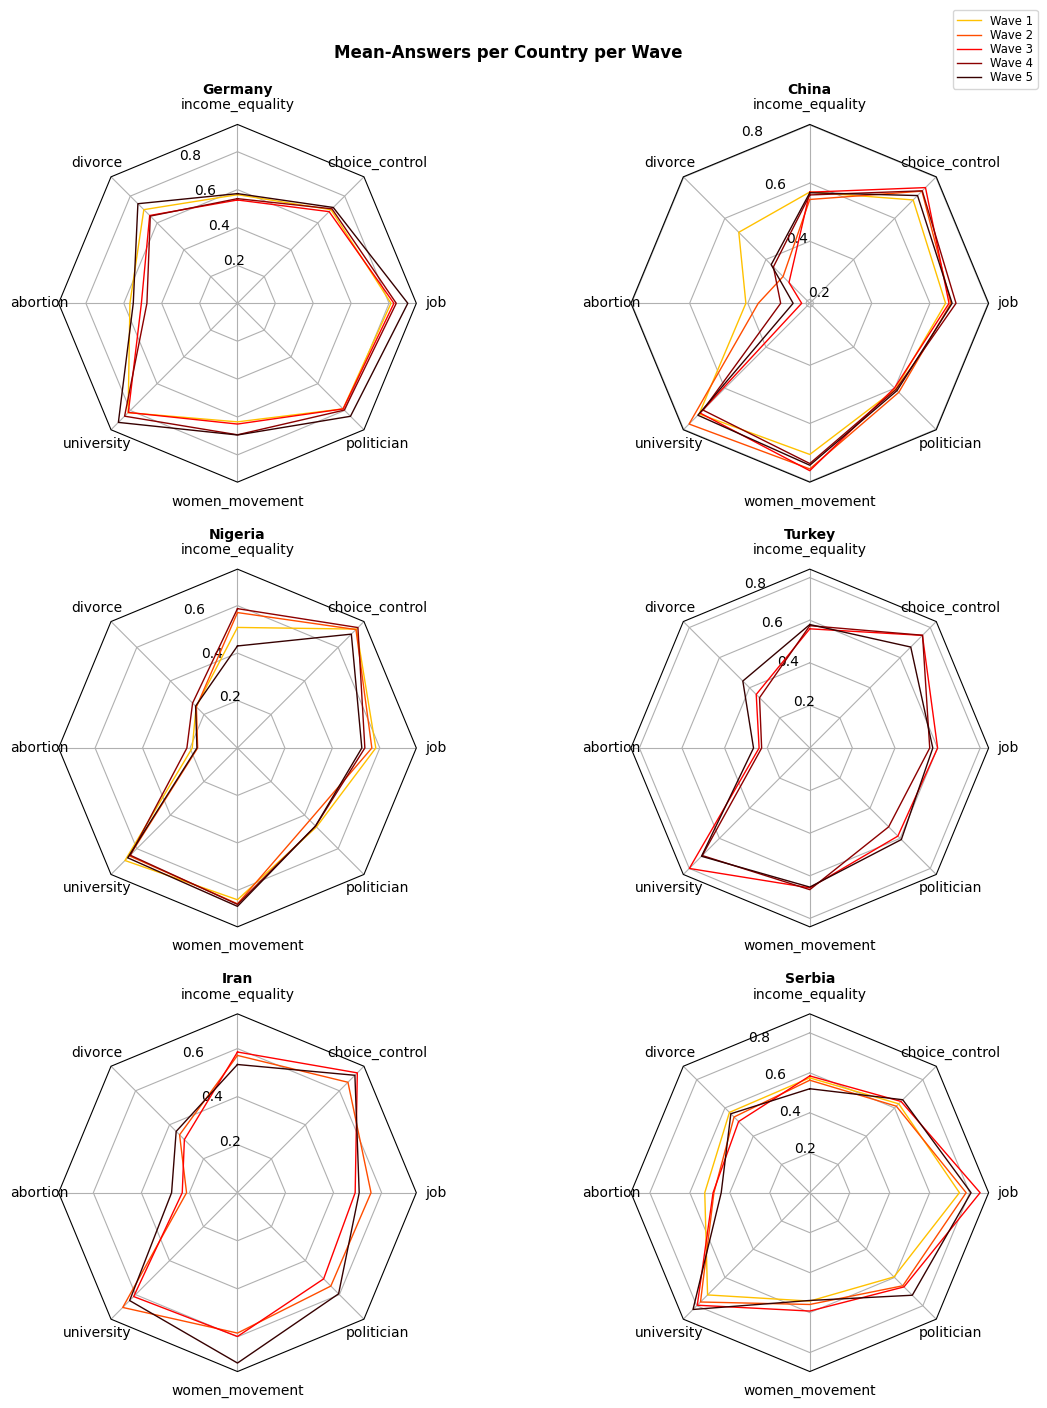

In [5]:
#TODO: Write radar chart for all countries in one
N = 8
theta = radar_factory(N, frame='polygon')

data = generate_data('waves')


spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(12, 12), nrows=3, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.6, hspace=0.20, top=1.1, bottom=0.05)

colors = ['#ffc100', '#ff4d00', '#ff0000', '#8c0000', '#360101'] #, '#ff9a00','#ff7400'
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color, linewidth=1)
        #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
# according to selected data, we have to select the correct labels
#labels=  ('Male', 'Female') 
labels = ('Wave 1', 'Wave 2', 'Wave 3', 'Wave 4', 'Wave 5')
legend = axs[0,1].legend(labels, loc=(0.9, 1.1),
                        labelspacing=0.1, fontsize='small')

fig.text(0.5, 1.15, 'Mean-Answers per Country per Wave',
        horizontalalignment='center', color='black', weight='bold',
        size='large')

plt.show()



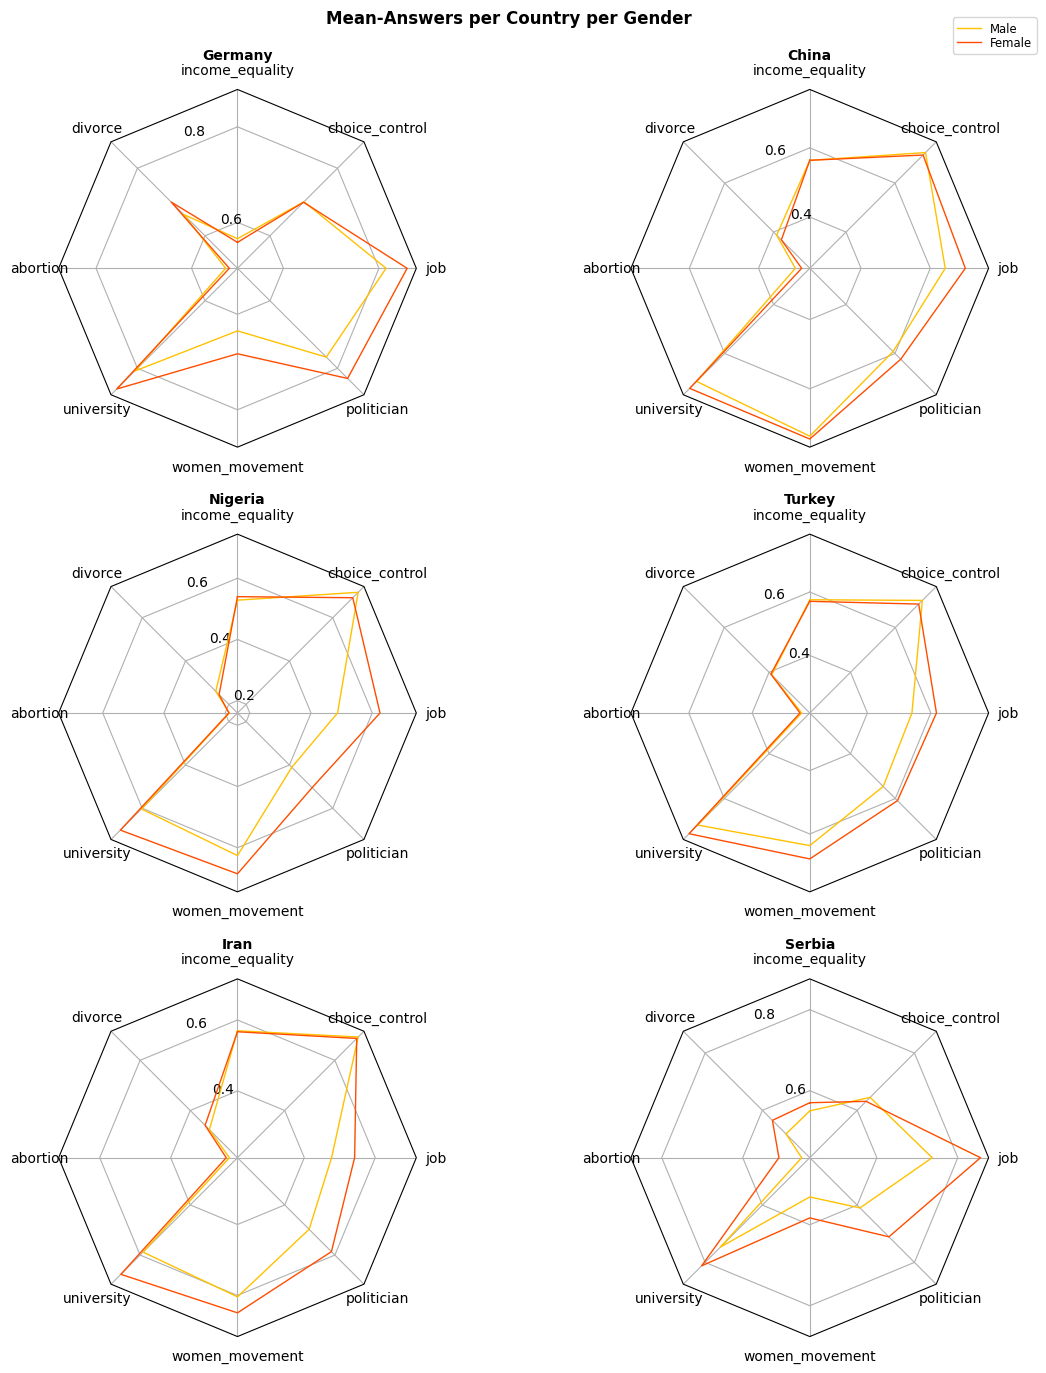

In [6]:
N = 8
theta = radar_factory(N, frame='polygon')

data = generate_data("gender")


spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(12, 12), nrows=3, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.6, hspace=0.20, top=1.1, bottom=0.05)

colors = ['#ffc100', '#ff4d00', '#ff0000', '#8c0000', '#360101'] #, '#ff9a00','#ff7400'
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color, linewidth=1)
        #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels=  ('Male', 'Female') 
legend = axs[0,1].legend(labels, loc=(0.9, 1.1),
                        labelspacing=0.1, fontsize='small')

fig.text(0.5, 1.15, 'Mean-Answers per Country per Gender',
        horizontalalignment='center', color='black', weight='bold',
        size='large')

plt.show()

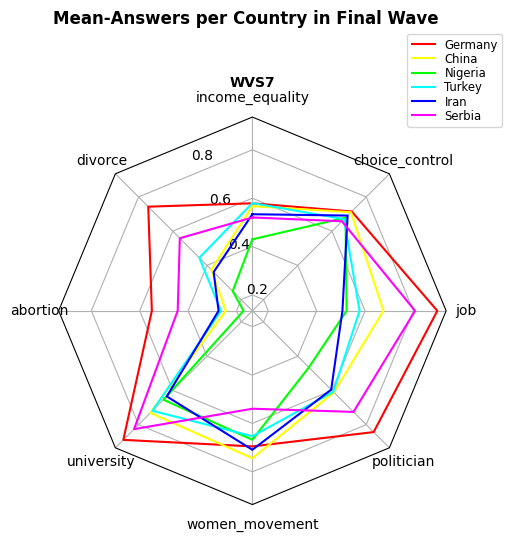

In [13]:
N = 8
theta = radar_factory(N, frame='polygon')

data = generate_data("countries")


spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(5, 5), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.6, hspace=0.20, top=1.1, bottom=0.05)

colors = ['#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF', '#FF00FF'] #, '#ff9a00','#ff7400'
# Plot the four cases from the example data on separate axes
for (title, case_data) in data:
    axs.set_rgrids([0.2, 0.4, 0.6, 0.8])
    axs.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        axs.plot(theta, d, color=color, linewidth=1.5)
        #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    axs.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels=  ('Germany', 'China', 'Nigeria', 'Turkey', 'Iran', 'Serbia')
legend = axs.legend(labels, loc=(0.9, 0.975),
                        labelspacing=0.1, fontsize='small')

fig.text(0.5, 1.15, 'Mean-Answers per Country in Final Wave',
        horizontalalignment='center', color='black', weight='bold',
        size='large')

plt.show()

In [ ]:
#TODO: Combine all kinds of plot into one beautifull figure